# Data set 1<br>
The data set 1 is obtained from the UCI repository. It contains information from sensors and has been used for time-series prediction. This data set contains two subsets. The first, captured during 2011 March, with 2764 instants (≈28 days), and the second, captured during 2011 June, with 1373 instants (≈14 days).  In total, 4136 time instants are available. The data from March will be used as the PS, and the data from June will be added by batches of different size.<br>
## Preliminaries<br>
Import and load the uses Python packages and modules:

In [1]:
import sys
import os
# Add the parent directory to sys.path
parent_directory = os.path.abspath(os.path.join(os.getcwd(), '../main/'))
sys.path.insert(0, parent_directory)
import pandas as pd
import numpy as np
import sim_experiments as smexp_dyn
from datetime import date
import autoversion_service as av
import autoversion_aemod as avae

Load the data set and prepare it:

In [2]:
dfps = pd.read_csv("../datasets/ds01-PS.txt", sep=" ")
dfps["1:Date"] = pd.to_datetime(dfps["1:Date"], format = '%d/%m/%Y')
dfps["DayMonth"] = dfps["1:Date"].dt.strftime('%m-%d')
dfps["MonthYear"] = dfps["1:Date"].dt.strftime('%m-%Y')
dfps.set_index(["1:Date", "2:Time"], inplace=True)
dfps = dfps.select_dtypes(include=[float, int]) # type: ignore
X_PS = dfps.iloc[:,:-1]

In [3]:
dfrev = pd.read_csv("../datasets/ds01-R.txt", sep=" ")
dfrev["1:Date"] = pd.to_datetime(dfrev["1:Date"], format = '%d/%m/%Y')
dfrev["DayMonth"] = dfrev["1:Date"].dt.strftime('%m-%d')
dfrev["MonthYear"] = dfrev["1:Date"].dt.strftime('%m-%Y')
dfrev.set_index(["1:Date", "2:Time"], inplace=True)
dfrev = dfrev.select_dtypes(include=[float, int]) # type: ignore
X_NEW = dfrev.iloc[:,:-1]

Exploratory analysis showing time series decomposigion as an additive model where each time instant ($x_i$) is the addition of a trend component ($T_i$), <br>
a seasonal component ($S_i$) and an error component ($E_i$)

In [4]:
smexp_dyn.plot_time_components_div(pd.concat([X_PS, X_NEW]), X_PS.index,  X_NEW.index, 96, dsname="ds01-demo", xtxtsize=6, path_figs="../figures/")

'done'

## Primary Source models<br>
Obtain the parameters for the reference batch of data. The function returns a dictionary *ps_dict* with the parameters to compute each one of the drift metrics according to a different ML model and the _indPS_ variable with the indices of the records used for the reference set.

Doing Primary Source Model -- 
N = 2764 (66.81 % of total dataset length)
Step [1/6]: Printing the Original Data Set Features =======
Step [1/6]: Starting ...
       3:Temperature_Comedor_Sensor  4:Temperature_Habitacion_Sensor  \
count                   2764.000000                      2764.000000   
mean                      19.199722                        18.824852   
std                        2.853315                         2.821178   
min                       11.352000                        11.076000   
25%                       17.450800                        17.060350   
50%                       19.373650                        19.021000   
75%                       21.229975                        20.828700   
max                       25.540000                        24.944000   

       5:Weather_Temperature  6:CO2_Comedor_Sensor  7:CO2_Habitacion_Sensor  \
count            2764.000000           2764.000000              2764.000000   
mean               13.897396      

2023-11-24 18:31:57.171364: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "my_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 14)                266       
                                                                 
 sequential_1 (Sequential)   (None, 18)                270       
                                                                 
Total params: 536
Trainable params: 536
Non-trainable params: 0
_________________________________________________________________
Best model - DONE
13/13 [==============================] - 0s 516us/step
Data model -  DONE
Permutation test -  DONE
dE-AE summary: 134.66680812835693 s.; 640 b.
Step [3/6]: Finished.


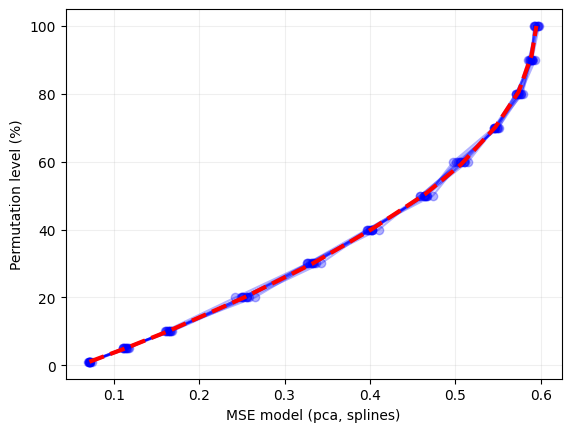

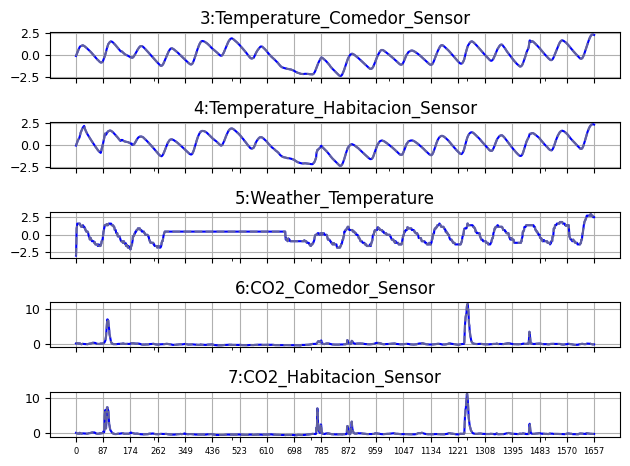

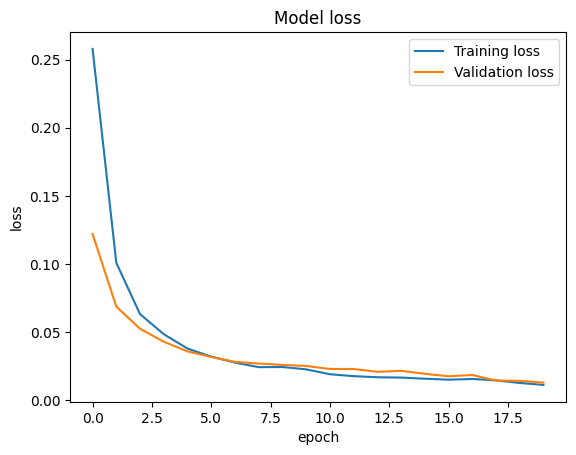

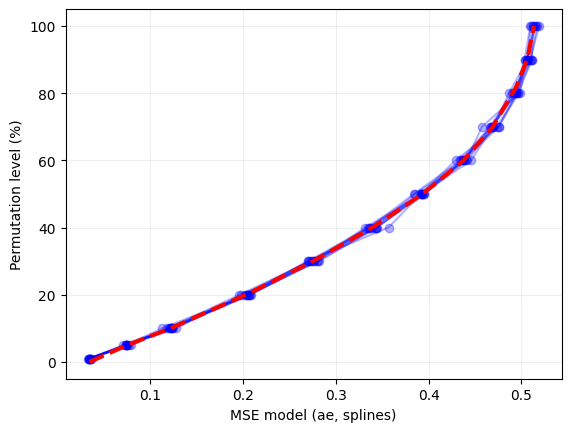

In [5]:
import random
import tensorflow as tf
tf.random.set_seed(42) 
np.random.seed(42)
random.seed(42)
#print(random.sample(range(1,100),3))
print("Doing Primary Source Model -- \n" + "N = " + str(len(X_PS)) + " (" + str(np.round(len(X_PS)/(len(X_PS) + len(X_NEW))*100,2)) + " %" + " of total dataset length)")
ps_dict, ind_PS = smexp_dyn.get_PS_data(X_PS, resultspath = "../results/ds01-demo/", dstitle = "DS 01 PS", PSfilename = "ds01ps.pkl",
                                        dopickle=False, pctge_PS=1, noisefactor = 0.1, mse_model_type="splines", resultsfile="dyn-ds-01")

### New versions<br>
When a new version of the dataset is generated, it will be compared to the information from the previous version in the following way:<br>
  * $d_{P}$: computes the cosine distance between loading matrices obtained for both data sets;<br>
  * $d_{E, PCA}$: computes the MSE obtained by reconstructing the new batch using the reference PCA model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>
  * $d_{E, AE}$: computes the MSE obtained by reconstructing the new batch using the reference AE model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.

## Creation events<br>
The following experiments use an initial subset as reference and add new batches of different size.

In [6]:
print("  - Case 1: add rows of new set \n")
# Add batches of 10% New Dataset records' size
ds01_c_demo = smexp_dyn.do_exp(X_NEW, ps_dict, resultspath = "../results/ds01-demo", mod_pca = True, mod_ae = True, 
                  mode_der = "add_batch", batchsize_pctges = [0.1], demo = True,
                  dstitle="DS 01 creation-demo", kfolds=0, resultsfile="/demo-ds01-creation")

__, vC_pca_dp = av.versionDER(ds01_c_demo, ps_dict["PS_dic"]["PCA"]["S"], outdict=True, loadfile=False, dstitle="DS 01 creation-demo pca-dP", cat_threshold=2)
__, vC_pca_de = av.versionDER(ds01_c_demo, ps_dict["PS_dic"]["PCA"]["E"], outdict=True, loadfile=False, dstitle="DS 01 creation-demo pca-dE", drift_dist="dE", 
                                  cat_threshold = 2)
vC_ae_de = avae.versionDER(ds01_c_demo, ps_dict["PS_dic"]["AE"], "../results/ds01-demo/aelogs/tb_logs", "../results/ds01-demo", outdict=True, loadfile=False,
                               dstitle="DS 01 creation-demo ae", cat_threshold = 2)

print("DS 01 - PS - v.tag: " + ps_dict["PS_dic"]["PCA"]["S"]["vtag"])
print("DS 01 - demo creation - PCA dP v.tag: " + vC_pca_dp["vtag"])
print("DS 01 - demo creation - PCA dE v.tag: " + vC_pca_de["vtag"])
print("DS 01 - demo creation - AE v.tag: " + vC_ae_de["vtag"])


  - Case 1: add rows of new set 

New versions, level 0.1- start
DS 01 - PS - v.tag: 1.0.<11/24/2023 - 17:31:39>
DS 01 - demo creation - PCA dP v.tag: 2.36.<11/24/2023 - 17:34:11>
DS 01 - demo creation - PCA dE v.tag: 1.7.<11/24/2023 - 17:34:11>
DS 01 - demo creation - AE v.tag: 2.3.<11/24/2023 - 17:34:11>


## Update events<br>

In [7]:
print("  - Case 2: transform columns ..\n")

ds01_u_demo = smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds01-demo", mode_der = "trans_cols",
                    tr_pctges = [0.5], dstitle="DS 01 update-demo", batchsize_pctges=[1], kfolds=1,
                    modetr="cbrt",resultsfile="/demo-ds01-trcols-cbrt", demo = True)

__, vU_pca_dp = av.versionDER(ds01_u_demo, ps_dict["PS_dic"]["PCA"]["S"], outdict=True, loadfile=False, dstitle="DS 01 update-demo pca-dP", cat_threshold=2)
__, vU_pca_de = av.versionDER(ds01_u_demo, ps_dict["PS_dic"]["PCA"]["E"], outdict=True, loadfile=False, dstitle="DS 01 update-demo pca-dE", drift_dist="dE", 
                                  cat_threshold = 2)
vU_ae_de = avae.versionDER(ds01_u_demo, ps_dict["PS_dic"]["AE"], "../results/ds01-demo/aelogs/tb_logs", "../results/ds01-demo", outdict=True, loadfile=False,
                               dstitle="DS 01 update-demo ae", cat_threshold = 2)

print("DS 01 - PS - v.tag: " + ps_dict["PS_dic"]["PCA"]["S"]["vtag"])
print("DS 01 - demo update - PCA dP v.tag: " + vU_pca_dp["vtag"])
print("DS 01 - demo update - PCA dE v.tag: " + vU_pca_de["vtag"])
print("DS 01 - demo update - AE v.tag: " + vU_ae_de["vtag"])

  - Case 2: transform columns ..

New versions, level [0.5]- start
DS 01 - PS - v.tag: 1.0.<11/24/2023 - 17:31:39>
DS 01 - demo update - PCA dP v.tag: 1.8.<11/24/2023 - 17:34:13>
DS 01 - demo update - PCA dE v.tag: 1.100.<11/24/2023 - 17:34:13>
DS 01 - demo update - AE v.tag: 1.100.<11/24/2023 - 17:34:13>


## Deletion events<br>
In the following cases, the reference set contains all the records and some of them are deleted in different ways: signals are down sampled, outliers are removed, etc.

In [8]:
print("  - Case 3: remove rows decimate .. \n")
ds01_d_demo = smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds01-demo", mode_der = "rem_rows_decimate",
                    tr_pctges = [0.5], dstitle="DS 01 deletion-demo", batchsize_pctges=[1], resultsfile="/demo-ds01-deletion", 
                    demo = True)

__, vD_pca_dp = av.versionDER(ds01_d_demo, ps_dict["PS_dic"]["PCA"]["S"], outdict=True, loadfile=False, dstitle="DS 01 deletion-demo pca-dP", cat_threshold=2)
__, vD_pca_de = av.versionDER(ds01_d_demo, ps_dict["PS_dic"]["PCA"]["E"], outdict=True, loadfile=False, dstitle="DS 01 deletion-demo pca-dE", drift_dist="dE", 
                                  cat_threshold = 2)
vD_ae_de = avae.versionDER(ds01_d_demo, ps_dict["PS_dic"]["AE"], "../results/ds01-demo/aelogs/tb_logs", "../results/ds01-demo", outdict=True, loadfile=False,
                               dstitle="DS 01 deletion-demo ae", cat_threshold = 2)

print("DS 01 - PS - v.tag: " + ps_dict["PS_dic"]["PCA"]["S"]["vtag"])
print("DS 01 - demo deletion - PCA dP v.tag: " + vD_pca_dp["vtag"])
print("DS 01 - demo deletion - PCA dE v.tag: " + vD_pca_de["vtag"])
print("DS 01 - demo deletion - AE v.tag: " + vD_ae_de["vtag"])

  - Case 3: remove rows decimate .. 

New versions, level [0.5]- start
DS 01 - PS - v.tag: 1.0.<11/24/2023 - 17:31:39>
DS 01 - demo deletion - PCA dP v.tag: 1.6.<11/24/2023 - 17:34:14>
DS 01 - demo deletion - PCA dE v.tag: 1.0.<11/24/2023 - 17:34:14>
DS 01 - demo deletion - AE v.tag: 1.0.<11/24/2023 - 17:34:14>


In [9]:
demo_results = pd.DataFrame({"datasets": "ds01-demo", 
                "PS": {"dPCA_P": ps_dict["PS_dic"]["PCA"]["S"]["vtag"], "dPCA_E":  ps_dict["PS_dic"]["PCA"]["E"]["vtag"], 
                       "dAE_E": ps_dict["PS_dic"]["AE"]["vtag"]},
                "creation": {"dPCA_P": vC_pca_dp["vtag"], "dPCA_E": vC_pca_de["vtag"], "dAE_E": vC_ae_de["vtag"]},
                "update": {"dPCA_P": vU_pca_dp["vtag"], "dPCA_E": vU_pca_de["vtag"], "dAE_E": vU_ae_de["vtag"]}, 
                "deletion": {"dPCA_P": vD_pca_dp["vtag"], "dPCA_E": vD_pca_de["vtag"], "dAE_E": vD_ae_de["vtag"]}})
if os.path.exists("../results/demos.xlsx"):
       with pd.ExcelWriter("../results/demos.xlsx", engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
              demo_results.to_excel(writer, sheet_name="ds01")
else:
       demo_results.to_excel("../results/demos.xlsx", sheet_name='ds01')  